<a href="https://colab.research.google.com/github/wezzylog/Tensorflow-Projects/blob/main/Potato_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
drive_dir_path = "drive/MyDrive/Potato project/PlantVillage"
os.chdir(drive_dir_path)
print(os.listdir())

['Potato___Late_blight', 'Potato___Early_blight', 'Potato___healthy']


In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Potato project/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)



Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


## Visualize some of the images from our dataset

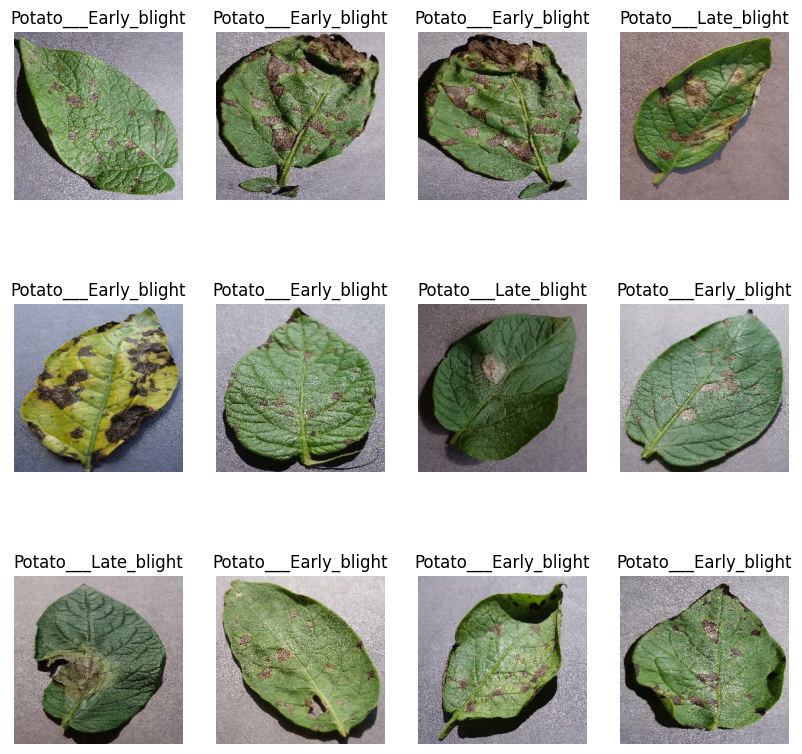

In [8]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

## Function for the splitting the dataset

Dataset should be bifurcated into 3 subsets, namely:

1)Training Dataset: Dataset to be used while training,

2)Validation Dataset: Dataset to be tested against while training,

3)Test Dataset: Dataset to be tested against after we trained a model.

In [9]:
len(dataset)

68

In [10]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_df(ds , train_split=0.8, val_split=0.1 , test_split=0.1,shuffle=True,shuffle_size=10000):
  assert(train_split + test_split + val_split) == 1

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size,seed=12)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds , val_ds , test_ds



In [17]:
train_ds , test_ds , val_ds = get_dataset_partitions_df(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(test_ds)

6

In [20]:
len(val_ds)

8

##Cache , Shuffle  and Prefetch the Dataset

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the model


### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it.

In [22]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),

])

###Data Augmenetation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying Data Augmentation to the Train Dataset

In [24]:
train_ds = train_ds.map(
    lambda x,y:(data_augmentation(x,training=True) , y)

).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [25]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3


model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

## Compiling the model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [27]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history_model = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 23s 432ms/step - loss: 0.9019 - accuracy: 0.5023 - val_loss: 0.8142 - val_accuracy: 0.6641
Epoch 2/50
54/54 [==============================] - 15s 286ms/step - loss: 0.7063 - accuracy: 0.6863 - val_loss: 0.5984 - val_accuracy: 0.7148
Epoch 3/50
54/54 [==============================] - 16s 290ms/step - loss: 0.4185 - accuracy: 0.8206 - val_loss: 0.2552 - val_accuracy: 0.8867
Epoch 4/50
54/54 [==============================] - 16s 295ms/step - loss: 0.3288 - accuracy: 0.8588 - val_loss: 0.2201 - val_accuracy: 0.9102
Epoch 5/50
54/54 [==============================] - 15s 282ms/step - loss: 0.2911 - accuracy: 0.8900 - val_loss: 0.1654 - val_accuracy: 0.9414
Epoch 6/50
54/54 [==============================] - 15s 284ms/step - loss: 0.2843 - accuracy: 0.8866 - val_loss: 0.2305 - val_accuracy: 0.9102
Epoch 7/50
54/54 [==============================] - 16s 287ms/step - loss: 0.2116 - accuracy: 0.9207 - val_loss: 0.1730 - val_accuracy: 0.9336

In [30]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 7s 28ms/step - loss: 0.1676 - accuracy: 0.9427


In [31]:
scores

[0.16759741306304932, 0.9427083134651184]

##Plotting the Accuracy and Loss Curves

In [32]:
history_model

In [33]:
history_model.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [35]:
history_model.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
type(history_model.history['loss'])

list

In [37]:
len(history_model.history['loss'])

50

In [38]:
history_model.history['loss'][:5]

[0.9019255042076111,
 0.7062846422195435,
 0.41852614283561707,
 0.32882916927337646,
 0.29108357429504395]

In [39]:
acc = history_model.history['accuracy']
val_acc = history_model.history['val_accuracy']

loss = history_model.history['loss']
val_loss = history_model.history['val_loss']

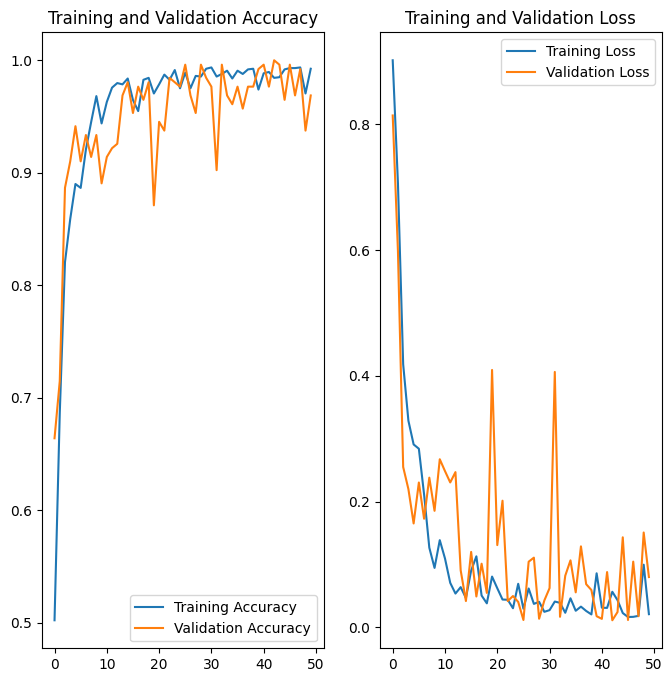

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Run a Prediction on the sample

first image to predict
actual label: Potato___healthy
1/1 [==============================] - 0s 31ms/step
predicted label: Potato___healthy


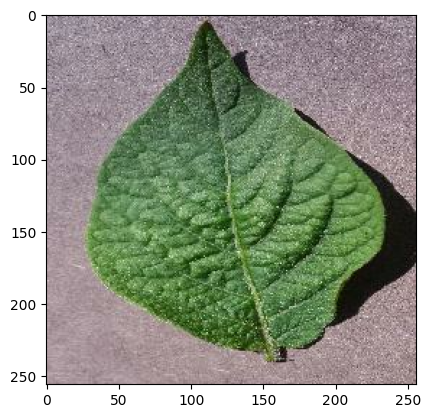

In [44]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype("uint8")
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:" , class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label:", class_names[np.argmax(batch_prediction[0])])

## Writing Function for inference

In [49]:
def predict(model, img):
  # Convert the image tensor to a NumPy array
  # img_as_numpy_array = img.numpy()

  # Convert the NumPy array to a PIL image
  img_array = tf.keras.preprocessing.image.img_to_array(img)

  # Expand the dimensions of the image array
  img_array = tf.expand_dims(img_array, 0)

  # Predict the class of the image
  predictions = model.predict(img_array)

  # Get the predicted class and confidence
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)

  # Return the predicted class and confidence
  return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


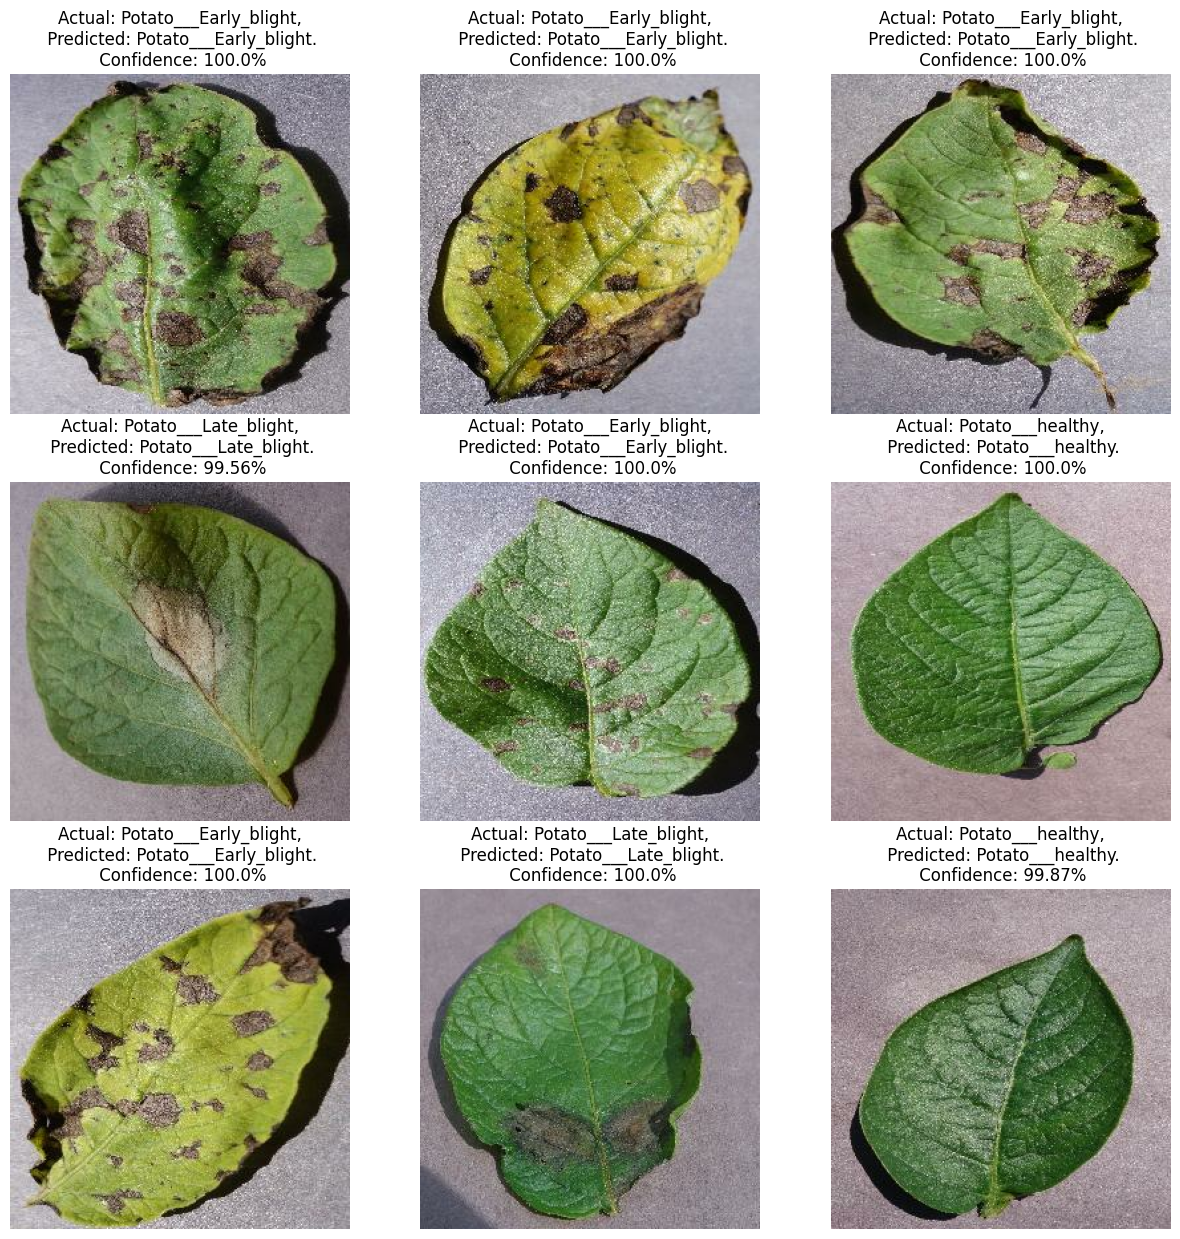

In [50]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

##Saving the model

In [54]:

model.save("../potatoes.keras")